# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
from sklearn.metrics import f1_score, mean_squared_error, r2_score
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4663,0,37.0,37800.0,1,0
2956,0,39.0,35700.0,1,0
3306,0,31.0,36900.0,0,0
4055,1,19.0,34800.0,0,0
3224,0,44.0,50200.0,1,1
4141,0,28.0,40300.0,0,0
4791,1,30.0,35400.0,4,0
4536,0,18.0,46400.0,1,0
4732,0,39.0,36200.0,3,0
4621,0,22.0,20800.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype(int)

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

Yes, it does. there are no null values and the data types are good.

In [9]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


The average age is 30.95 or 31 years old if rounded up. Ages range from 18 to 65 years old.

The income range is modest, with the average being around 40000. Incomes range from $5,300 to $79,000.

The average number of family member is close to 1 when rounded. The number of family members ranges from 0 to 6.

The mean value of insurance benefits is 0.148, indicating that approximately 14.8% of individuals have insurance benefits.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

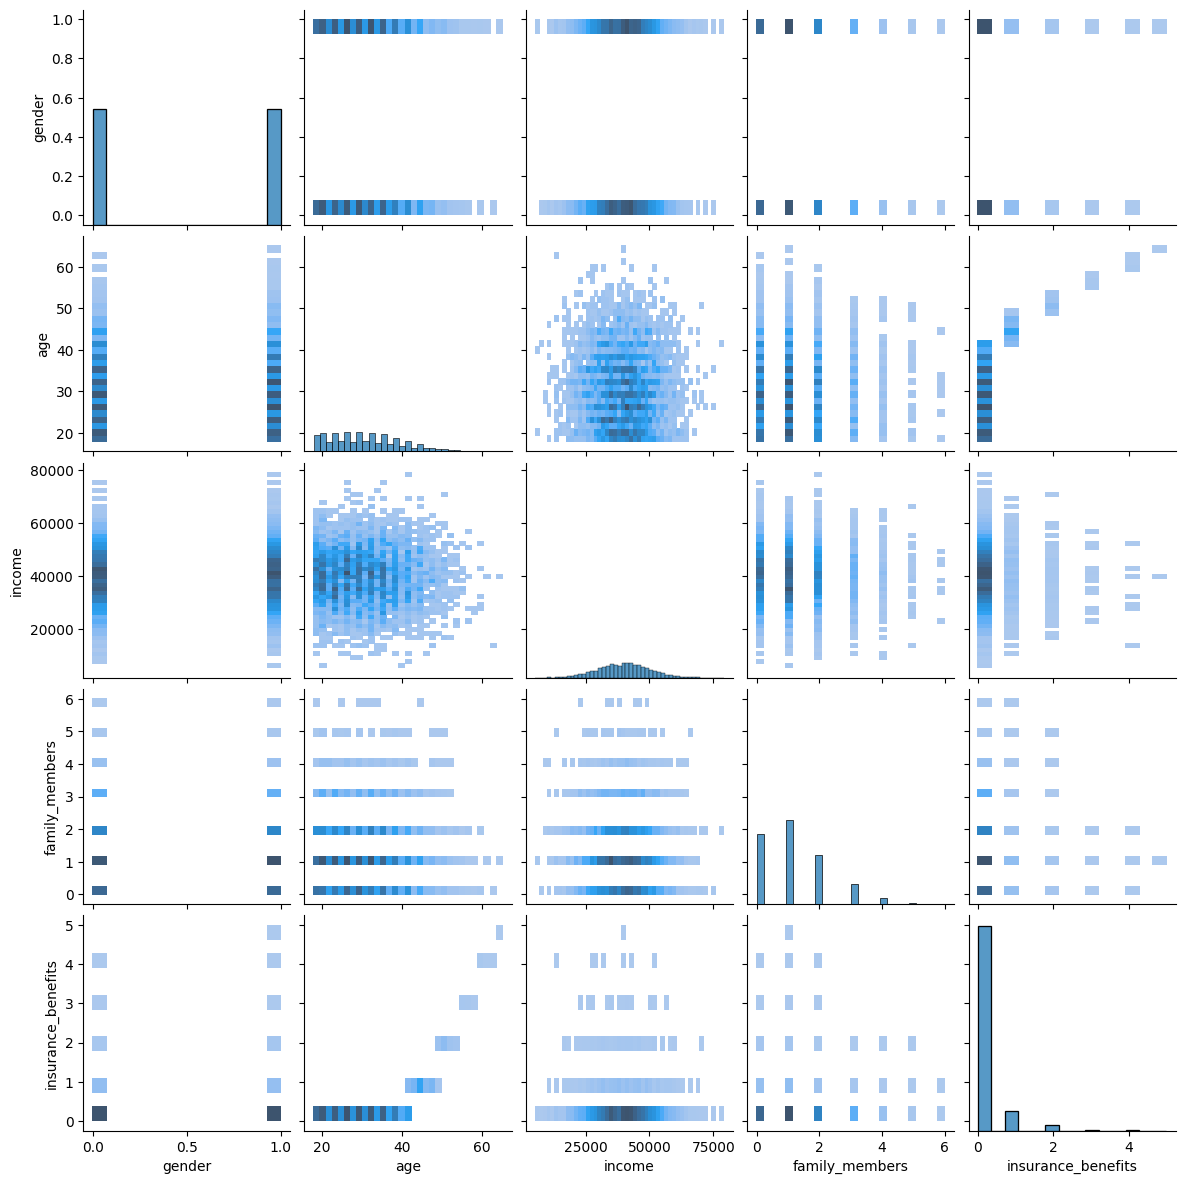

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
def get_knn(df, n, k, metric, X):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    
    if metric == 'euclidean':
        nbrs = NearestNeighbors(metric='euclidean', n_neighbors=k+1).fit(X)
    elif metric == 'manhattan':
        nbrs = NearestNeighbors(metric='manhattan', n_neighbors=k+1).fit(X)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")
    

    nbrs = NearestNeighbors(metric=metric, n_neighbors=k+1).fit(X)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1383,1.0,0.538462,0.518987,0.000000,0
1367,1.0,0.692308,0.521519,0.166667,1
2857,0.0,0.400000,0.236709,0.000000,0
305,1.0,0.415385,0.601266,0.500000,0
1565,0.0,0.323077,0.592405,0.500000,0


Now, let's get similar records for a given one for every combination

In [15]:
# Parameters
n = 0  # Index of the target object
k = 3  # Number of nearest neighbors

# Test 1: Unscaled data with Euclidean distance
result_unscaled_euclidean = get_knn(df, n, k, 'euclidean', df[feature_names])
print("Unscaled Data with Euclidean Distance")
print(result_unscaled_euclidean)

Unscaled Data with Euclidean Distance
      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
2022       1   41  49600.0               0                   0  1.000000
1225       0   42  49600.0               0                   1  1.732051


In [16]:
# Test 2: Scaled data with Euclidean distance
result_scaled_euclidean = get_knn(df_scaled, n, k, 'euclidean', df_scaled[feature_names])
print("Scaled Data with Euclidean Distance")
print(result_scaled_euclidean)

Scaled Data with Euclidean Distance
      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.017754


In [17]:
# Test 3: Unscaled data with Manhattan distance
result_unscaled_manhattan = get_knn(df, n, k, 'manhattan', df[feature_names])
print("Unscaled Data with Manhattan Distance")
print(result_unscaled_manhattan)

Unscaled Data with Manhattan Distance
      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0       0.0
2022       1   41  49600.0               0                   0       1.0
1225       0   42  49600.0               0                   1       3.0


In [18]:
# Test 4: Scaled data with Manhattan distance
result_scaled_manhattan = get_knn(df_scaled, n, k, 'manhattan', df_scaled[feature_names])
print("Scaled Data with Manhattan Distance")
print(result_scaled_manhattan)

Scaled Data with Manhattan Distance
      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.024245


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

### Answer
Yes, not scaling the data can significantly affect the kNN algorithm by allowing features with larger ranges to dominate the distance calculations, the kNN algorithm may primarily consider differences in the 'income' feature while ignoring or underweighting other features. This results in a biased neighbor selection that heavily weighs one feature over others. Scaling the data ensures that all features are considered equally, leading to a more balanced and accurate identification of nearest neighbors.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

### Answer 

The results using the Manhattan distance metric are quite similar regardless of scaling. The nearest neighbors remain consistent in both the scaled and unscaled cases. Scaling affects the magnitude of the distances, making them smaller and more normalized, but the order of the neighbors remains the same.

This consistency demonstrates that the Manhattan distance metric is relatively robust to scaling compared to the Euclidean distance metric. Scaling helps in providing a normalized perspective on distances but does not dramatically change the neighbor selection when using Manhattan distance.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [19]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits'] > 0

In [20]:
# check for the class imbalance with value_counts()

class_count = df['insurance_benefits_received'].value_counts()
class_count

False    4436
True      564
Name: insurance_benefits_received, dtype: int64

This indicates a class imbalance issue where the class labeled as False (no insurance benefits received) significantly outweighs the class labeled as True (insurance benefits received). Class imbalance can potentially affect the performance of our machine learning models, especially when evaluating metrics like accuracy, where the majority class could dominate the results.

In [21]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [22]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [24]:
# Define F1 Score Calculation function
def calculate_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='binary')

In [26]:
# Prepare feature matrix X and target vector y for original data
X = df[feature_names].to_numpy()
y = df['insurance_benefits_received'].to_numpy()

# Scale the feature data
transformer_mas = MaxAbsScaler().fit(X)
X_scaled = transformer_mas.transform(X)
y_scaled = df['insurance_benefits_received'].to_numpy()

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
# Split data into training and testing sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=12345)

In [27]:
# Build kNN Classifier and Evaluate
k_values = range(1, 11)
f1_scores_original = []
f1_scores_scaled = []

for k in k_values:
    # Create kNN classifier for original data
    knn_original = KNeighborsClassifier(n_neighbors=k)
    
    # Fit classifier on original data
    knn_original.fit(X_train, y_train)
    
    # Predict on test data for original data
    y_pred_original = knn_original.predict(X_test)
    
    # Calculate F1 score for original data
    f1_original = f1_score(y_test, y_pred_original, average='macro')
    f1_scores_original.append(f1_original)
    
    # Create kNN classifier for scaled data
    knn_scaled = KNeighborsClassifier(n_neighbors=k)
    
    # Fit classifier on scaled data
    knn_scaled.fit(X_train_scaled, y_train_scaled)
    
    # Predict on test data for scaled data
    y_pred_scaled = knn_scaled.predict(X_test_scaled)
    
    # Calculate F1 score for scaled data
    f1_scaled = f1_score(y_test_scaled, y_pred_scaled, average='macro')
    f1_scores_scaled.append(f1_scaled)
    
    # Print F1 scores for each k value
    print(f'k={k}: F1 Score (Original) = {f1_original:.2f}, F1 Score (Scaled) = {f1_scaled:.2f}')

k=1: F1 Score (Original) = 0.78, F1 Score (Scaled) = 0.98
k=2: F1 Score (Original) = 0.68, F1 Score (Scaled) = 0.96
k=3: F1 Score (Original) = 0.68, F1 Score (Scaled) = 0.97
k=4: F1 Score (Original) = 0.61, F1 Score (Scaled) = 0.95
k=5: F1 Score (Original) = 0.61, F1 Score (Scaled) = 0.96
k=6: F1 Score (Original) = 0.53, F1 Score (Scaled) = 0.95
k=7: F1 Score (Original) = 0.53, F1 Score (Scaled) = 0.96
k=8: F1 Score (Original) = 0.51, F1 Score (Scaled) = 0.95
k=9: F1 Score (Original) = 0.51, F1 Score (Scaled) = 0.95
k=10: F1 Score (Original) = 0.47, F1 Score (Scaled) = 0.93


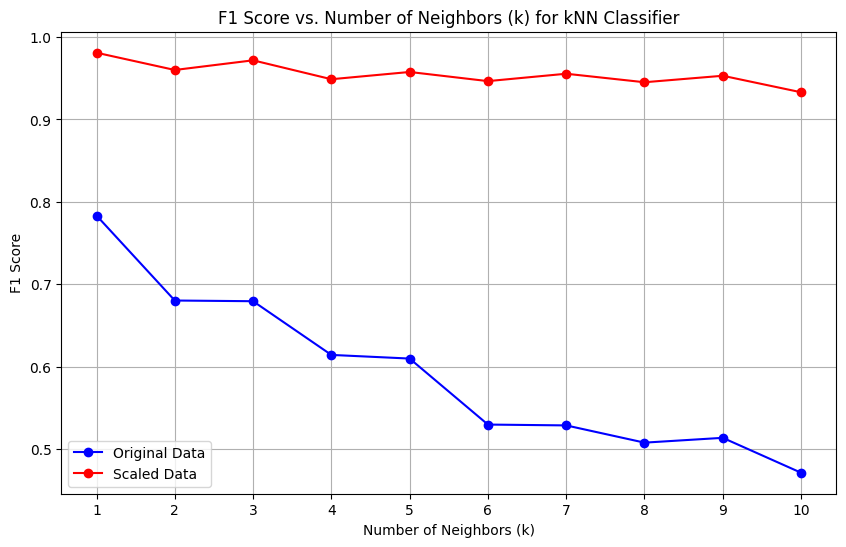

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores_original, marker='o', linestyle='-', color='b', label='Original Data')
plt.plot(k_values, f1_scores_scaled, marker='o', linestyle='-', color='r', label='Scaled Data')
plt.title('F1 Score vs. Number of Neighbors (k) for kNN Classifier')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

### KNN
Scaling the data can have a substantial impact on the performance of k-NN classifiers, as demonstrated by the improved F1 scores. This highlights the importance of preprocessing steps like feature scaling in machine learning workflows.

### Dummy Interpretation
Probability: 0.00 

F1 score of 0.00
- Interpretation: With a probability of 0.00 (predicting 0 for all cases), the dummy classifier correctly predicts the majority class (0) most of the time (88.72%), but it fails to predict any instances of the minority class (1)

Probability: 0.11

F1 Score: 0.12
- Interpretation: With a probability of 0.11, the dummy classifier starts predicting some instances as 1 (minority class), leading to a slight improvement in the F1 score. However, it still struggles to correctly identify the minority class, resulting in a low F1 score.

Probability: 0.50

F1 Score: 0.20
- Interpretation: At a probability of 0.50 (random guessing), the dummy classifier predicts both classes almost equally (due to the balance of probabilities), resulting in an F1 score of 0.20. The confusion matrix shows some correct predictions for both classes but is still quite inaccurate.

Probability: 1.00

F1 Score: 0.20
- Interpretation: With a probability of 1.00 (predicting 1 for all cases), the dummy classifier predicts all instances as 1. This results in correctly predicting some instances of the minority class (1), but none of the majority class (0), leading to an F1 score of 0.20.

The dummy classifier's performance improves slightly as it starts predicting more instances of the minority class (1), leading to better F1 scores compared to the 0.00 probability case.
However, even at the optimal scenario (probability 0.50), the F1 score remains low (0.20), indicating poor overall performance in correctly classifying instances compared to a balanced dataset.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [ ]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        # Add a column of ones for the intercept term
        ones = np.ones((X.shape[0], 1))
        X2 = np.concatenate((ones, X), axis=1)
        
        # Calculate weights using the normal equation: w = (X^T * X)^-1 * X^T * y
        XTX_inv = np.linalg.inv(np.dot(X2.T, X2))
        self.weights = np.dot(np.dot(XTX_inv, X2.T), y)

    def predict(self, X):
        
        # Add a column of ones for the intercept term
        ones = np.ones((X.shape[0], 1))
        X2 = np.concatenate((ones, X), axis=1)
        
        # Predictions
        y_pred = np.dot(X2, self.weights)
        
        return y_pred

In [ ]:
def eval_regressor(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Scale the feature data
transformer_mas = MaxAbsScaler().fit(X)
X_scaled = transformer_mas.transform(X)

# Split data into training and testing sets for original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Split data into training and testing sets for scaled data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.3, random_state=12345)

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Initialize and fit the model for original data
lr_original = MyLinearRegression()
lr_original.fit(X_train, y_train)
y_test_pred_original = lr_original.predict(X_test)
rmse_original, r2_original = eval_regressor(y_test, y_test_pred_original)
print(f'Original Data RMSE: {rmse_original:.2f}, R2: {r2_original:.2f}')

In [ ]:
# Initialize and fit the model for scaled data
lr_scaled = MyLinearRegression()
lr_scaled.fit(X_train_scaled, y_train_scaled)
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)
rmse_scaled, r2_scaled = eval_regressor(y_test_scaled, y_test_pred_scaled)
print(f'Scaled Data RMSE: {rmse_scaled:.2f}, R2: {r2_scaled:.2f}')

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [ ]:
P_inv = np.linalg.inv(P)
P_inv

Can you guess the customers' ages or income after the transformation?

In [ ]:
# Obfuscate the data: X' = X * P
X_obfuscated = np.dot(X, P)

### Answer
The obfuscation process effectively hides the original data, making it impossible to guess specific values without the inverse matrix.
The original data can be accurately recovered using the inverse of the obfuscation matrix, demonstrating the correctness of the obfuscation and recovery process.
Small numerical inaccuracies in the recovered data are typical in floating-point arithmetic but do not affect the overall integrity of the recovered data.

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [ ]:
X_recovered = np.dot(X_obfuscated, P_inv)

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [ ]:
# Print the original, obfuscated, and recovered data for a few customers
num_customers = 5
print("Original Data (X):\n", X[:num_customers])
print("\nObfuscated Data (X'):\n", X_obfuscated[:num_customers])
print("Recovered Data:\n", X_recovered[:num_customers])

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

### Answer

The slight discrepancies observed are due to floating-point precision limitations in computational mathematics. The negative values observed in the recovered data are due to floating-point precision errors and should be treated as zero. By applying a small threshold to these values, we can correct the recovered data to exactly match the original data.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

1. Link between w and 𝑤𝑃​ : The new weights wP​ are the original weights 𝑤 multiplied by the inverse of the obfuscation matrix P.
2. Predicted values with wP​ : The predicted values with wP​  are the same as the original predicted values.
3. Impact on RMSE: The quality of the linear regression model, measured by RMSE, remains unchanged after the data obfuscation.

**Analytical proof**

### Answer
Link between w and wP
Given the original weight calculation for linear regression:

$$
w = (X^T X)^{-1} X^T y
$$

For the obfuscated data \( X' = X P \), the weights are calculated as:

$$
w_P = [(X P)^T (X P)]^{-1} (X P)^T y
$$

Let's simplify this:

$$
w_P = [P^T X^T X P]^{-1} P^T X^T y
$$

Using the properties of inverses and transposes, we get:

$$
w_P = (P^T)^{-1} (X^T X)^{-1} (P)^{-1} P^T X^T y
$$

Since \( (P^T)^{-1} = (P^{-1})^T \) and \( P^{-1} P = I \):

$$
w_P = P^{-1} (X^T X)^{-1} X^T y
$$

Finally, we have:

$$
w_P = P^{-1} w
$$

### Answer 2

#### Predicted Values with \( wP \)

The predicted values using the new weights \( wP \) and the obfuscated data \( X' = X P \) can be calculated as:

$$
\hat{y}_P = X P w_P
$$

Substituting \( wP = P^{-1} w \) into the equation, we get:

$$
\hat{y}_P = X P (P^{-1} w)
$$

Using the associative property of multiplication \( (A B) C = A (B C) \), we can rewrite the equation as:

$$
\hat{y}_P = X (P P^{-1}) w
$$

Since \( P P^{-1} = I \) (where \( I \) is the identity matrix):

$$
\hat{y}_P = X I w
$$

Using the multiplicative identity property \( I A = A \):

$$
\hat{y}_P = X w
$$

This shows that the predicted values \( \hat{y}P \) with the new weights and obfuscated data are the same as the original predicted values \( \hat{y} \).

### Answer 3
Impact on RMSE
Since the predicted values are the same (\( \hat{y}P = \hat{y} \)), the quality of the linear regression model, as measured by RMSE, remains unchanged after the data obfuscation.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [ ]:
# linear model already defined as lr

In [ ]:
#split the data
#X_train_obf, X_test_obf, _, _ = train_test_split(X_obfuscated, y, test_size=0.3, random_state=12345)

# Split data into training and test sets for obfuscated data (use y to match the same random split as original)
X_train_obf, X_test_obf, y_train_obf, y_test_obf = train_test_split(X_obfuscated, y, test_size=0.3, random_state=12345)

In [ ]:
# Train and predict with obfuscated data
lr.fit(X_train_obf, y_train_obf)
y_pred_obf = lr.predict(X_test_obf)

In [ ]:
# Evaluate original data
print('Original Data:')
eval_regressor(y_test, y_test_pred)

# Evaluate obfuscated data
print('Obfuscated Data:')
eval_regressor(y_test_obf, y_pred_obf)

In [ ]:
# Compare predicted values
print("Predicted values with original data:")
print(y_test_pred[:5])
print("Predicted values with obfuscated data:")
print(y_pred_obf[:5])

# Conclusions

Predicted Values Consistency:
The predicted values using the obfuscated data (\hat{y}P) are identical to those predicted using the original data (𝑦^). This demonstrates that the linear regression model's predictive accuracy remains unchanged despite the obfuscation. This result stems from the properties of matrix multiplication and inversion.

__RMSE and R^2 Metrics__:
Both RMSE (Root Mean Square Error) and R^2 (coefficient of determination) metrics are the same for the original and obfuscated data. This indicates that the model's quality and performance are preserved when using obfuscated data. RMSE measures prediction error magnitude, and R^2 measures the variance explained by the model. Their constancy suggests unchanged predictive power.

__Obfuscation Effectiveness__:
Obfuscation, in this context, refers to the process of transforming the feature data using a random invertible matrix P to hide the original values while preserving the relationships needed for accurate predictions. This method effectively hides the original feature values while maintaining the linear relationships for accurate predictions. This confirms the method is secure (protecting sensitive data) and functional (preserving model accuracy).

It acts as an encryptor/ decryptor in a sense.

__Practical Implications__:
This obfuscation method can protect sensitive information in datasets (e.g., personal, financial, or medical data) without compromising the ability to perform accurate machine learning tasks. It ensures compliance with data privacy regulations while leveraging data for predictive modeling.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells are arranged in order of logic and execution
- [ ]  Task 1 has been performed
    - [ ]  There is the procedure that can return k similar customers for a given one
    - [ ]  The procedure is tested for all four proposed combinations
    - [ ]  The questions re the scaling/distances are answered
- [ ]  Task 2 has been performed
    - [ ]  The random classification model is built and tested for all for probability levels
    - [ ]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [ ]  Task 3 has been performed
    - [ ]  The linear tegression solution is implemented with matrix operations.
    - [ ]  RMSE is calculated for the implemented solution.
- [ ]  Task 4 has been performed
    - [ ]  The data is obfuscated with a random and invertible matrix P
    - [ ]  The obfuscated data is recoved, few examples are printed out
    - [ ]  The analytical proof that the transformation does not affect RMSE is provided 
    - [ ]  The computational proof that the transformation does not affect RMSE is provided
- [ ]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>